<center><image src="https://drive.google.com/uc?id=1n3G4TdK_u6PQHcLrxB_A0HijNdigXmUH">

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Домашнее задание можно разделить на следующие части:

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]
* Мир других лоссов! [2]
  * Dice Loss [1]
  * Focal Loss [1]
  * BONUS: лосс из статьи [5]
* Новая модель! [2]
  * UNet [2]


**Максимальный балл:** 10 баллов.

Также для студентов желающих еще более углубиться в задачу предлагается решить бонусное задание, которое даст дополнительные 5 баллов. BONUS задание необязательное.


# Загрузка данных

1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>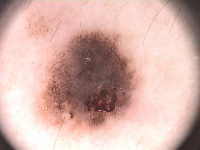</td><td>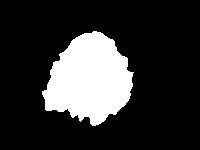</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [1]:
!gdown 1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql

Downloading...
From (original): https://drive.google.com/uc?id=1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql
From (redirected): https://drive.google.com/uc?id=1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql&confirm=t&uuid=e329186a-1664-42d7-b50e-cf4d1179f2b0
To: /kaggle/working/PH2Dataset.rar
100%|████████████████████████████████████████| 162M/162M [00:06<00:00, 24.6MB/s]


In [2]:
get_ipython().system_raw("unrar x PH2Dataset.rar")


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from PH2Dataset.rar

Program aborted




Would you like to replace the existing file PH2Dataset/PH2 Dataset images/IMD002/IMD002_Dermoscopic_Image/IMD002.bmp
1313366 bytes, modified on 2020-07-03 15:00
with a new one
1313366 bytes, modified on 2020-07-03 15:00

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit 

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [3]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [4]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [5]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

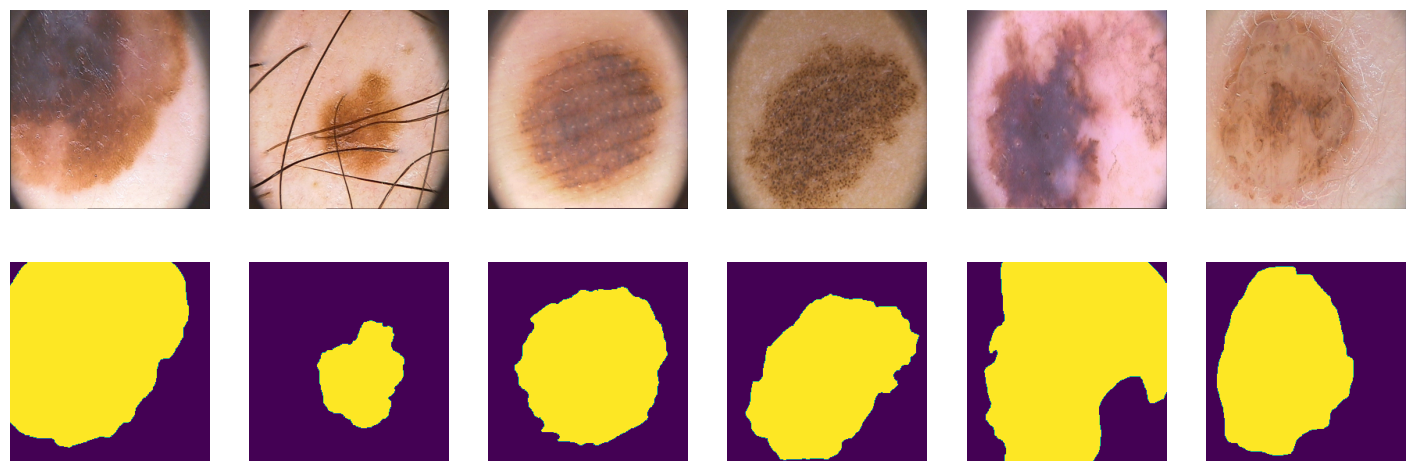

In [6]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [7]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [8]:
print(len(tr), len(val), len(ts))

100 50 50


## PyTorch DataLoader

In [9]:
from torch.utils.data import DataLoader

batch_size = 25
train_dataloader = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [10]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Метрика

## IoU (intersection over union)

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Что будет являться пересением и объединением в задаче сегментации?

Давайте разберем следующий пример:



<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1rBYFgli48AUUN9idiyq8j3J5DboB93yN" width=1000 height=800/></p>

In [11]:
# !pip install torchmetrics

In [12]:
from torchmetrics import JaccardIndex

iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)


# Построй свой первый бейзлайн!

Итак, загрузка файлов, код датасета и даталоадера написана за вас. Метрика IoU написана за вас! Вам остается написать лосс, модель и функции обучения и теста модели.

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]

## BCE Loss [2 балла]

Популярным лоссом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

### Вывод численно стабильной формулы BCE лосса [1 балл]



Выведите из формулы [1] формулу [2]:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

Не забываем, что здесь $\hat y_i$ - это логиты сети, не вероятности и не лейблы.

**Ответ:**

$$
\begin{align*}
&[1] = y \cdot -\log(\sigma(\hat{y})) + (1 - y) \cdot -\log(1 - \sigma(\hat{y})) \\
&= y \cdot -\log\left(\frac{1}{1 + e^{-\hat{y}}}\right) + (1 - y) \cdot -\log\left(\frac{e^{-\hat{y}}}{1 + e^{-\hat{y}}}\right) \\
&= y \cdot \log(1 + e^{-\hat{y}}) + (1 - y) \cdot \left(-\log(e^{-\hat{y}}) + \log(1 + e^{-\hat{y}})\right) \\
&= y \cdot \log(1 + e^{-\hat{y}}) + (1 - y) \cdot (\hat{y} + \log(1 + e^{-\hat{y}})) \\
&= (1 - y) \cdot \hat{y} + \log(1 + e^{-\hat{y}}) \\
&= \hat{y} - y \cdot \hat{y} + \log(1 + e^{-\hat{y}}) = [2]
\end{align*}

$$

### Реализуйте в коде оба варианта лосса [1 балл]

Реализуйте следующие функции:

*   `bce_true()` - честная прямая реализация лосса с формулой $$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$
*   `bce_loss()` - реализация формулы, которую мы вывели $$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

И сравните результаты функций с реализацией Pytorch:
*   `bce_torch()`
*   `bce_torch_with_logits()`

In [13]:
import torch.nn.functional as F
import torch.nn as nn

In [14]:
bce_torch = nn.BCELoss(reduction='sum') # (sigmoid(y_pred), y_real)
bce_torch_with_logits = nn.BCEWithLogitsLoss(reduction='sum')

In [15]:
def bce_loss(y_pred: torch.Tensor, y_real: torch.Tensor):
  return -(torch.sum(y_real * F.logsigmoid(y_pred)) + torch.sum((1-y_real)*torch.log(1 - torch.sigmoid(y_pred))))
  

def bce_true(y_pred: torch.Tensor, y_real: torch.Tensor):
  return torch.sum(y_pred - y_real*y_pred + torch.log(1 + torch.exp(-y_pred)))
  

Проверим корректность работы на простом примере

In [16]:
y_pred = torch.randn(3, 2, requires_grad=False)
y_true = torch.rand(3, 2, requires_grad=False)

print(f'BCE loss from scratch bce_loss = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch = {bce_torch(torch.sigmoid(y_pred), y_true)}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true)}')


BCE loss from scratch bce_loss = 5.625836372375488
BCE loss честно посчитанный = 5.625836372375488
BCE loss from torch bce_torch = 5.625836372375488
BCE loss from torch with logits bce_torch = 5.625836372375488


Инструкции `assert` в Python — это булевы выражения, которые проверяют, является ли условие истинным (`True`). Внизу в коде мы проверяем функция `bce_loss()` выдает тот же результат, что и функция из Pytorch или нет. Если равенства не будет, что будет означать, что результаты функций не совпадают, а значит вы неправильно реализовали фукнцию `bce_loss()`, `assert` возвратит ошибку.

Функция `numpy.isclose()` используется для сравнения двух чисел с учётом допустимой погрешности. Она особенно полезна при работе с числами с плавающей точкой, где точное сравнение может быть проблематичным из-за ограничений представления таких чисел в компьютере.

Как она работает?

`numpy.isclose(a, b, rtol=1e-05, atol=1e-08) `принимает два числа (`a` и `b`) и сравнивает их, учитывая относительную и абсолютную погрешность. Если разница между двумя числами меньше заданного порога, функция возвращает `True`, иначе — `False`.

Параметры:

    rtol: Относительная погрешность (по умолчанию 1e-05). Используется для определения разницы относительно большего значения.
    atol: Абсолютная погрешность (по умолчанию 1e-08). Определяет минимальную разницу, которую следует учитывать.

Мы будем использовать `assert` и `numpy.isclose()` для проверки корректности нашего кода.

In [17]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))

Давайте теперь посчитаем на простом примере, но с теми же размерностями, что и в датасете

In [18]:
y_pred = torch.randn((2, 1, 3, 3), requires_grad=False)
y_true = torch.randint(0, 2, (2, 1, 3, 3))

print(f'BCE loss from scratch bce_loss = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch = {bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float))}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true.to(torch.float))}')

BCE loss from scratch bce_loss = 13.251246452331543
BCE loss честно посчитанный = 13.251245498657227
BCE loss from torch bce_torch = 13.251245498657227
BCE loss from torch with logits bce_torch = 13.251245498657227


In [19]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))

Давайте посчитаем на реальных логитах и сегментационной маске:

In [20]:
!gdown --folder 1EX0RW1TRQVkLmR1h6miCQqyhYPFyg28M

Retrieving folder contents
Processing file 1-0A7_CS_vKiSCkgIDJ4joThCEcFedA3I logits.pt
Processing file 1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC labels.pt
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1-0A7_CS_vKiSCkgIDJ4joThCEcFedA3I
To: /kaggle/working/for_asserts/logits.pt
100%|██████████████████████████████████████| 1.18k/1.18k [00:00<00:00, 5.13MB/s]
Downloading...
From: https://drive.google.com/uc?id=1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC
To: /kaggle/working/for_asserts/labels.pt
100%|██████████████████████████████████████| 1.18k/1.18k [00:00<00:00, 5.88MB/s]
Download completed


In [21]:
path_to_dummy_samples = './for_asserts'
dummpy_sample = {'logits': torch.load(f'{path_to_dummy_samples}/logits.pt'),
                 'labels': torch.load(f'{path_to_dummy_samples}/labels.pt')}
dummpy_sample['labels'] = dummpy_sample['labels'].to(device)
dummpy_sample['logits'] = dummpy_sample['logits'].to(device)

/tmp/ipykernel_183/3257238461.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dummpy_sample = {'logits': torch.load(f'{path_to_dummy_samples}/logits.pt'),
/tmp/ipykernel

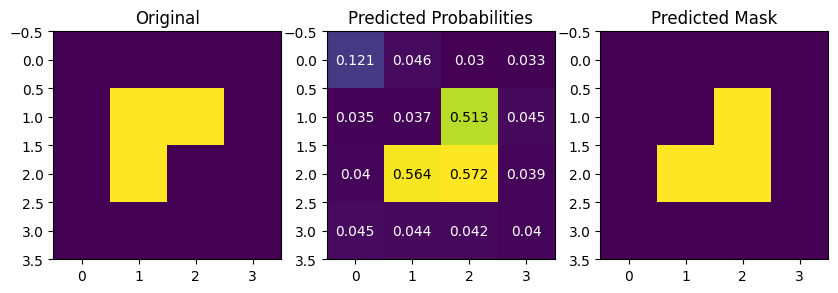

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize= (10,3*10))

ax1.imshow(dummpy_sample['labels'].squeeze(1)[0].cpu())
ax1.set_title("Original")

ax2.imshow(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu())
for (j,i),label in np.ndenumerate(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu()):
    if label < 0.5:
        color = 'white'
    else:
        color = 'black'
    ax2.text(i,j,round(label,3), color=color, ha='center',va='center')

ax2.set_title("Predicted Probabilities")

ax3.imshow((dummpy_sample['logits'].sigmoid() > 0.5).squeeze(1)[0].cpu())
ax3.set_title("Predicted Mask")
plt.show()

Проверяем на данном примере:

In [23]:
bce_loss_score = bce_loss(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_true_score = bce_true(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_torch_score = bce_torch(torch.sigmoid(dummpy_sample['logits'].cpu()), dummpy_sample['labels'].cpu().float())
bce_torch_with_logits_score = bce_torch_with_logits(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu().float())

assert np.isclose(bce_loss_score, bce_torch_score)
assert np.isclose(bce_loss_score, bce_torch_with_logits_score)
assert np.isclose(bce_true_score, bce_torch_score)
assert np.isclose(bce_true_score, bce_torch_with_logits_score)

## SegNet [2 балла]

Ваше задание здесь состоит в том, чтобы реализовать SegNet архитектуру.

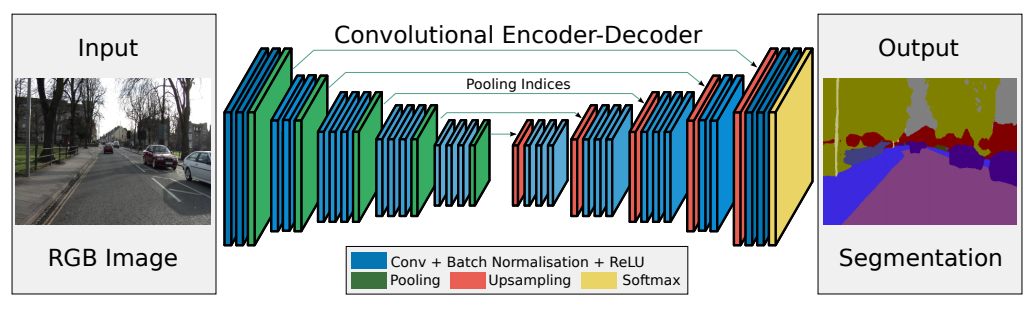

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time


from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

Хорошие ресурсы по SegNet архитектуре:
1. https://medium.com/@nikdenof/segnet-from-scratch-using-pytorch-3fe9b4527239


Ресурс на архитекутуру VGG16: https://www.digitalocean.com/community/tutorials/vgg-from-scratch-pytorch

In [25]:
class ConvReLU(nn.Module):
    def __init__(self, in_c, out_c, kernel_size=3, padding=1) -> None:
        super(ConvReLU, self).__init__()
        self.conv = nn.Conv2d(in_c, out_c, kernel_size=kernel_size, padding=padding)
        self.bn = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class EncoderBlock(nn.Module):
    def __init__(self, in_c, out_c, depth=2, kernel_size=3, padding=1) -> None:
        super(EncoderBlock, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(depth):
            self.layers.append(ConvReLU(in_c if i == 0 else out_c, out_c, kernel_size, padding))
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x, ind = self.pool(x)
        return x, ind
    

class DecoderBlock(nn.Module):
    def __init__(self, in_c, out_c, depth=2, kernel_size=3, padding=1, classification=False) -> None:
        super(DecoderBlock, self).__init__()
        self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.layers = nn.ModuleList()
        for i in range(depth):
            if i == depth - 1 and classification:
                self.layers.append(nn.Conv2d(in_c, out_c, kernel_size=kernel_size, padding=padding))
            elif i == depth - 1:
                self.layers.append(ConvReLU(in_c, out_c, kernel_size=kernel_size, padding=padding))
            else:
                self.layers.append(ConvReLU(in_c, in_c, kernel_size=kernel_size, padding=padding))

    def forward(self, x, ind):
        x = self.unpool(x, ind)
        for layer in self.layers:
            x = layer(x)
        return x


class SegNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()

        # encoder VGG-16 architecture
        features = 64
        self.enc0 = EncoderBlock(in_channels, features, depth=2) # 64
        self.enc1 = EncoderBlock(features, features*2, depth=2) # 128
        self.enc2 = EncoderBlock(features*2, features*4, depth=3) # 256
        self.enc3 = EncoderBlock(features*4, features*8, depth=3) # 512

        # bottleneck
        self.bottleneck_enc = EncoderBlock(features * 8, features * 8, depth=3) 
        self.bottleneck_dec = DecoderBlock(features * 8, features * 8, depth=3) 
        
        # decoder (upsampling)
        self.dec0 = DecoderBlock(features * 8, features * 4, depth=3)
        self.dec1 = DecoderBlock(features * 4, features * 2, depth=3)
        self.dec2 = DecoderBlock(features * 2, features)
        self.dec3 = DecoderBlock(features, out_channels, classification=True) # No activation


    def forward(self, x):
        # encoder
        e0, ind0 = self.enc0(x) 
        e1, ind1 = self.enc1(e0) 
        e2, ind2 = self.enc2(e1) 
        e3, ind3 = self.enc3(e2)

        # bottleneck
        b0, indb = self.bottleneck_enc(e3)
        b1 = self.bottleneck_dec(b0, indb)

        # decoder
        d0 = self.dec0(b1, ind3)
        d1 = self.dec1(d0, ind2)
        d2 = self.dec2(d1, ind1)

        output = self.dec3(d2, ind0)  
        return output # no activation

In [26]:
segnet_model = SegNet()

## Тренировка [1 балл]

Напишите функцию для обучения модели.

In [27]:
import torch
from torchmetrics import JaccardIndex

from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

In [28]:
from tqdm.notebook import tqdm

In [29]:
def train_single_epoch(model, optimizer, criterion, train_dataloader, device):
    model.train()

    avg_loss = 0
    for X_batch, Y_batch in tqdm(train_dataloader):
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        Y_pred = model(X_batch)
        loss = criterion(Y_pred, Y_batch) # forward-pass

        loss.backward()  # backward-pass
        optimizer.step()  # update weights
        optimizer.zero_grad() # set parameter gradients to zero

        # calculate loss to show the user
        avg_loss += loss

    avg_loss = avg_loss/len(train_dataloader)

    return model, avg_loss


def validate_single_epoch(model, criterion, valid_dataloader, device):

    iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)
    model.eval()

    avg_loss = 0
    avg_iou = 0
    with torch.no_grad():
      for X_batch, Y_batch in tqdm(valid_dataloader):
          X_batch = X_batch.to(device)
          Y_batch = Y_batch.to(device)

          Y_pred = model(X_batch)
          iou = iou_score(Y_pred, Y_batch)
          loss = criterion(Y_pred, Y_batch)
          avg_loss += loss
          avg_iou += iou

    avg_loss = avg_loss/len(valid_dataloader)
    avg_iou = avg_iou/len(valid_dataloader)

    return model, avg_loss, avg_iou

def train(model, optimizer, criterion, epochs, train_dataloader, valid_dataloader, device, ckpt_path):

    total_train_loss = []
    total_val_loss = []
    total_val_iou = []

    best_val_loss = float('inf')

    for epoch in tqdm(range(epochs)):

        model, train_loss = train_single_epoch(model, optimizer, criterion, train_dataloader, device)
        model, val_loss, val_iou = validate_single_epoch(model, criterion, valid_dataloader, device)
        print(f'Epoch {epoch}: train loss = {train_loss}')
        print(f'Epoch {epoch}: val loss = {val_loss}')
        print(f'Epoch {epoch}: val iou = {val_iou}')

        total_train_loss.append(train_loss.cpu().detach().numpy())
        total_val_loss.append(val_loss.cpu().detach().numpy())
        total_val_iou.append(val_iou.cpu().detach().numpy())

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'{ckpt_path}/best_val_loss.pt')


    statistics = {'train loss': total_train_loss,
                  'val_loss': total_val_loss,
                  'val_iou': total_val_iou}

    return model, statistics


Обучите модель **SegNet**. В качестве оптимайзера можно взять Adam.

In [30]:
model = segnet_model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss(reduction='sum')
epochs = 20

In [31]:
ckpt_path = './segnet_checkpoints'
os.makedirs(ckpt_path, exist_ok=True) 


In [32]:
model, statistics = train(model, optimizer, criterion, epochs, train_dataloader, valid_dataloader, device, ckpt_path)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0: train loss = 1057255.25
Epoch 0: val loss = 1118987.875
Epoch 0: val iou = 0.0


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1: train loss = 723222.75
Epoch 1: val loss = 1096507.5
Epoch 1: val iou = 0.10319065302610397


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2: train loss = 523842.125
Epoch 2: val loss = 1056718.0
Epoch 2: val iou = 0.029410142451524734


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3: train loss = 451044.0625
Epoch 3: val loss = 1420033.25
Epoch 3: val iou = 0.06358696520328522


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4: train loss = 445786.25
Epoch 4: val loss = 1922050.0
Epoch 4: val iou = 0.054050229489803314


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5: train loss = 402924.96875
Epoch 5: val loss = 1337129.125
Epoch 5: val iou = 0.10732810199260712


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 6: train loss = 378305.75
Epoch 6: val loss = 849073.875
Epoch 6: val iou = 0.5006818771362305


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 7: train loss = 439656.40625
Epoch 7: val loss = 629830.5625
Epoch 7: val iou = 0.6309943199157715


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 8: train loss = 383576.1875
Epoch 8: val loss = 611422.125
Epoch 8: val iou = 0.639142632484436


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 9: train loss = 396322.03125
Epoch 9: val loss = 482473.1875
Epoch 9: val iou = 0.673335611820221


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10: train loss = 379409.125
Epoch 10: val loss = 486116.8125
Epoch 10: val iou = 0.6487252712249756


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 11: train loss = 357390.125
Epoch 11: val loss = 438461.5625
Epoch 11: val iou = 0.7100939750671387


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 12: train loss = 347668.5
Epoch 12: val loss = 470453.96875
Epoch 12: val iou = 0.727228045463562


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 13: train loss = 319065.5625
Epoch 13: val loss = 374865.375
Epoch 13: val iou = 0.7557671666145325


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 14: train loss = 329535.125
Epoch 14: val loss = 339874.75
Epoch 14: val iou = 0.7777520418167114


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 15: train loss = 313724.90625
Epoch 15: val loss = 308068.90625
Epoch 15: val iou = 0.7976614236831665


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 16: train loss = 323042.15625
Epoch 16: val loss = 324510.28125
Epoch 16: val iou = 0.7784221172332764


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 17: train loss = 293031.25
Epoch 17: val loss = 322674.375
Epoch 17: val iou = 0.782755434513092


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 18: train loss = 301320.375
Epoch 18: val loss = 462372.0625
Epoch 18: val iou = 0.7349874377250671


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 19: train loss = 299112.5
Epoch 19: val loss = 391333.78125
Epoch 19: val iou = 0.7589383721351624


## Инференс [1 балл]

После обучения модели напишите фукнцию теста, воспользуйтесь лучшим чекпоинтом и протестируйте работу модели на тестовой выборке.

In [35]:

def test(model, test_dataloader, device, ckpt_path, ckpt_name):

    model.load_state_dict(torch.load(f'{ckpt_path}/{ckpt_name}'))
    model = model.to(device)
    model.eval()

    iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)
    avg_iou = 0
    
    with torch.no_grad():
      for X_batch, Y_batch in test_dataloader:
          X_batch = X_batch.to(device)
          Y_batch = Y_batch.to(device)

          Y_pred = model(X_batch.to(device))
          avg_iou += iou_score(Y_pred, Y_batch) # , threshold = 0.5)
      avg_iou = avg_iou / len(test_dataloader)

    return avg_iou

In [36]:
!ls segnet_checkpoints

best_val_loss.pt     epoch_15_val_iou.pt  epoch_3_val_iou.pt
epoch_0_val_iou.pt   epoch_16_val_iou.pt  epoch_4_val_iou.pt
epoch_10_val_iou.pt  epoch_17_val_iou.pt  epoch_5_val_iou.pt
epoch_11_val_iou.pt  epoch_18_val_iou.pt  epoch_6_val_iou.pt
epoch_12_val_iou.pt  epoch_19_val_iou.pt  epoch_7_val_iou.pt
epoch_13_val_iou.pt  epoch_1_val_iou.pt   epoch_8_val_iou.pt
epoch_14_val_iou.pt  epoch_2_val_iou.pt   epoch_9_val_iou.pt


In [37]:
test(model, test_dataloader, device, ckpt_path, "best_val_loss.pt")

/tmp/ipykernel_183/1397368121.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'{ckpt_path}/{ckpt_name}'))


tensor(0.7244, device='cuda:0')

# Мир других лоссов!

## Дополнительные функции потерь [2 балла]

В данном разделе вам потребуется имплементировать две функции потерь: DICE и Focal loss.


### Dice Loss

**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

В терминах матрицы ошибок она будет считаться следующим образом:

$$D(X,Y) = \frac{2TP}{2TP + FP + FN}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1- D(X, Y)$$

**Hints** (!):

1. Не забудьте подумать о численной нестабильности, возникающей в математической формуле при ситуации, когда $\frac{0}{0}$, т.е. вам нужно добавить очень маленькое число, например $\epsilon = 1e^{-8}$, в обе части дроби при подсчете $D(X,Y)$:

$$D(X,Y) = \frac{2TP + ϵ}{2TP + FP + FN + ϵ}$$

2. Dice метрика(!), не лосс, считается похожим образом как IoU:

    2.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    2.2. Фиксируем порог, например threshold=0.5, и всему что ниже порога ставим значение 0, всему что выше 1. Получаем предсказанную маску из 0 и 1.

    2.3. Считаем TP, FP, FN

    2.4. Считаем DICE метрику по формуле

Вы можете прописать для себя функцию `dice_score()` и сравнить с результатами работы функции.

1. Но с метрикой есть проблема, что она не дифференцируема, и если вы захотите просто взять и прописать `dice_loss` = 1 - `dice_score`, Pytorch поругается на вас и скажет, что это недифференцируемая метрика. Чтобы посчитать dice_loss делаем следующие шаги:

    3.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    3.2. Здесь нам уже не нужно фиксировать порог, мы просто работаем с вероятностями. Значения вероятностей дифференцируемы и через них будут протекать градиенты.

    3.3. Считаем TP, FP, FN также как и в Dice метрике, только вместо маски, подаем вероятности.

    3.4. Считаем DICE метрику по формуле

    3.5. Считаем лосс как Loss = 1 - DICE

In [38]:
!pip install segmentation-models-pytorch

Итак, давайте сначала пропишем dice_score.

In [39]:
def dice_score(logits: torch.Tensor, labels: torch.Tensor, threshold: float = 0.5):
    '''
    Это именно метрика, не лосс.
    '''
    
    prob_mask = logits.sigmoid()
    pred_mask = (prob_mask > threshold).float()

    tp = torch.sum(pred_mask*labels)
    fp = torch.sum(pred_mask) - tp
    fn = torch.sum(labels) - tp

    eps = 1e-8 # to avoid 0/0
    score = (2*tp + eps) / (2*tp + fp + fn + eps)
    

    return score


Проверим на корректность функцию dice_score:

In [40]:
from torchmetrics.segmentation import DiceScore


dice_score(dummpy_sample['logits'].unsqueeze(0), dummpy_sample['labels'].to(int))
print(dice_score(dummpy_sample['logits'].unsqueeze(0), dummpy_sample['labels'].to(int)))

dice = DiceScore(num_classes=2, average="micro", input_format="one-hot").to(device)


dice(dummpy_sample['logits'].sigmoid() > 0.5, dummpy_sample['labels'])

tensor(0.6667, device='cuda:0')


tensor(0.6667, device='cuda:0')

In [41]:
assert dice(dummpy_sample['logits'].sigmoid() > 0.5, dummpy_sample['labels'].to(int)) == dice_score(dummpy_sample['logits'], dummpy_sample['labels'])

Давайте теперь пропишем лосс и воспользуемся библиотекой `segmentation-models-pytorch`, чтобы убедиться в корректности нашей функции.

In [42]:
def dice_loss(logits: torch.Tensor, labels: torch.Tensor):

    '''
    Это лосс.
    '''
    
    prob_mask = logits.sigmoid()

    tp = torch.sum(prob_mask*labels)
    fp = torch.sum(prob_mask) - tp
    fn = torch.sum(labels) - tp

    eps = 1e-8 # to avoid 0/0
    loss = (2*tp + eps) / (2*tp + fp + fn + eps)

    return 1- loss

Проверка на корректность:

In [43]:
from segmentation_models_pytorch.losses import DiceLoss


dice_loss_torch = DiceLoss(mode='binary')
print(
    dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels']))

dice_loss(dummpy_sample['logits'], dummpy_sample['labels'])

tensor(0.5756, device='cuda:0')


tensor(0.5756, device='cuda:0')

In [44]:
assert dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'].to(int)) == dice_loss(dummpy_sample['logits'], dummpy_sample['labels'])

### Focal Loss

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.


Из оригинальной статьи по [Focal Loss](https://arxiv.org/pdf/1708.02002.pdf):

$$p_t = \sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)$$

$$\mathcal L_{focal}(y, \hat y) = (1 - p_t)^{\gamma} \mathcal L_{BCE}(y_i, \hat y_i).$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - p_t)^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - (\sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)))^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

In [45]:
import torch

def focal_loss(y_real: torch.Tensor, y_pred: torch.Tensor, gamma: float = 2.0) -> torch.Tensor:
    p = torch.sigmoid(y_pred)
    p_t = p * y_real + (1 - p) * (1 - y_real)
    focal_weight = (1 - p_t) ** gamma
    bce_loss = - (y_real * torch.log(p) + (1 - y_real) * torch.log(1 - p))
    loss = focal_weight * bce_loss
    return loss.sum()

print(focal_loss(dummpy_sample['labels'], dummpy_sample['logits']))

tensor(3.6161, device='cuda:0')


Проверка корректности функции:

In [48]:
from torchvision.ops import sigmoid_focal_loss

print(sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum'))
focal_loss(dummpy_sample['labels'], dummpy_sample['logits'])

tensor(3.6161, device='cuda:0')


tensor(3.6161, device='cuda:0')

In [47]:
assert np.isclose(sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum').cpu(), focal_loss(dummpy_sample['labels'], dummpy_sample['logits']).cpu())

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее, и провести численное сравнение с предыдущими функциями.

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Буду делать Tversky loss 

### Формула Tversky:
$$
\mathcal{T}(P, G; \alpha, \beta) = \frac{\sum_i p_i g_i}{\sum_i p_i g_i + \alpha \sum_i p_i (1 - g_i) + \beta \sum_i (1 - p_i) g_i}
$$

Где:
- $p_i$ — вероятность принадлежности к положительному классу (из softmax/sigmoid)
- $ g_i$ — бинарная маска (ground truth)
-  $\alpha, \beta$ — коэффициенты для контроля веса FP и FN


Смысл Tversky loss — это гибкая альтернатива Dice loss, позволяющая управлять балансом между precision и recall,


При $\alpha = \beta = 0.5$ является обычным Dice


In [49]:
def dice_loss(logits: torch.Tensor, labels: torch.Tensor):

    '''
    Это лосс.
    '''
    
    prob_mask = logits.sigmoid()

    tp = torch.sum(prob_mask*labels)
    fp = torch.sum(prob_mask) - tp
    fn = torch.sum(labels) - tp

    eps = 1e-8 # to avoid 0/0
    loss = (2*tp + eps) / (2*tp + fp + fn + eps)

    return 1- loss

In [51]:
import torch
import torch.nn as nn


class TverskyLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.5, eps=1e-6):
        super(TverskyLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.eps = eps  # для избежания деления на 0

    def forward(self, y_pred, y_true):
        y_pred = y_pred.view(-1).sigmoid()
        y_true = y_true.view(-1)

        TP = (y_pred * y_true).sum()
        FP = (y_pred * (1 - y_true)).sum()
        FN = ((1 - y_pred) * y_true).sum()

        tversky_index = (TP + self.eps) / (TP + self.alpha * FP + self.beta * FN + self.eps)
        return 1 - tversky_index


Должны совпадать 

In [52]:
print(dice_loss(dummpy_sample['logits'], dummpy_sample['labels']))

t_l = TverskyLoss()

t_l(dummpy_sample['logits'], dummpy_sample['labels'])

tensor(0.5756, device='cuda:0')


tensor(0.5756, device='cuda:0')

Совпадают

## Обучите SegNet на новых лоссах

**Задание**: обучите SegNet на новых лоссах и сравните все три лосса:
*   При каком лоссе модель сходится быстрее?
*   При каком лоссе модель выдает наилучшую метрику?

Напишите развернутый ответ на вопросы.



### Model Dice Loss

In [53]:
import torch

torch.cuda.empty_cache()

import gc

gc.collect()
torch.cuda.empty_cache()


In [54]:
segnet_model_dice_loss = SegNet().to(device)

model = segnet_model_dice_loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

criterion = dice_loss_torch
epochs = 20

ckpt_path = './segnet_dice_checkpoints'
os.makedirs(ckpt_path, exist_ok=True) 


In [55]:
model, statistics_dice = train(model, optimizer, criterion, epochs, train_dataloader, valid_dataloader, device, ckpt_path)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0: train loss = 0.602740466594696
Epoch 0: val loss = 0.5929690599441528
Epoch 0: val iou = 1.3301521903485991e-05


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1: train loss = 0.5812292098999023
Epoch 1: val loss = 0.5874131917953491
Epoch 1: val iou = 0.3519579768180847


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2: train loss = 0.5351595878601074
Epoch 2: val loss = 0.5774006247520447
Epoch 2: val iou = 0.34907466173171997


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3: train loss = 0.4855479598045349
Epoch 3: val loss = 0.528748631477356
Epoch 3: val iou = 0.3490740954875946


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4: train loss = 0.44510507583618164
Epoch 4: val loss = 0.49386486411094666
Epoch 4: val iou = 0.3639453053474426


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5: train loss = 0.39087730646133423
Epoch 5: val loss = 0.46385475993156433
Epoch 5: val iou = 0.40232691168785095


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 6: train loss = 0.35419660806655884
Epoch 6: val loss = 0.4814065396785736
Epoch 6: val iou = 0.3573716878890991


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 7: train loss = 0.331895112991333
Epoch 7: val loss = 0.37932491302490234
Epoch 7: val iou = 0.5751634836196899


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 8: train loss = 0.2964015305042267
Epoch 8: val loss = 0.29915329813957214
Epoch 8: val iou = 0.6320322155952454


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 9: train loss = 0.276752233505249
Epoch 9: val loss = 0.27228811383247375
Epoch 9: val iou = 0.6446956396102905


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10: train loss = 0.2531498372554779
Epoch 10: val loss = 0.2752189338207245
Epoch 10: val iou = 0.6351284980773926


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 11: train loss = 0.2291938215494156
Epoch 11: val loss = 0.2509160339832306
Epoch 11: val iou = 0.655500054359436


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 12: train loss = 0.20936405658721924
Epoch 12: val loss = 0.2272307276725769
Epoch 12: val iou = 0.6982970833778381


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 13: train loss = 0.19004695117473602
Epoch 13: val loss = 0.20565393567085266
Epoch 13: val iou = 0.7331489324569702


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 14: train loss = 0.1688070148229599
Epoch 14: val loss = 0.22336485981941223
Epoch 14: val iou = 0.6991978287696838


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 15: train loss = 0.17152009904384613
Epoch 15: val loss = 0.2204892635345459
Epoch 15: val iou = 0.7142746448516846


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 16: train loss = 0.16633425652980804
Epoch 16: val loss = 0.18936306238174438
Epoch 16: val iou = 0.739033043384552


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 17: train loss = 0.16047403216362
Epoch 17: val loss = 0.15061309933662415
Epoch 17: val iou = 0.7949588894844055


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 18: train loss = 0.1436408907175064
Epoch 18: val loss = 0.14612454175949097
Epoch 18: val iou = 0.7899608612060547


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 19: train loss = 0.1445670872926712
Epoch 19: val loss = 0.26170614361763
Epoch 19: val iou = 0.6149570941925049


In [56]:
test(model, test_dataloader, device, ckpt_path, "best_val_loss.pt")

/tmp/ipykernel_183/1397368121.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'{ckpt_path}/{ckpt_name}'))


tensor(0.7265, device='cuda:0')

### Model Focal Loss

In [57]:
segnet_model_focal_loss = SegNet().to(device)

from torchvision.ops import sigmoid_focal_loss


def focal_loss_fn(logits, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    return sigmoid_focal_loss(logits, targets, alpha=alpha, gamma=gamma, reduction=reduction)


model = segnet_model_focal_loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = focal_loss_fn
epochs = 20

ckpt_path = './segnet_focal_checkpoints'
os.makedirs(ckpt_path, exist_ok=True) 


In [58]:
model, statistics_focal = train(model, optimizer, criterion, epochs, train_dataloader, valid_dataloader, device, ckpt_path)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0: train loss = 0.11839540302753448
Epoch 0: val loss = 0.09566543996334076
Epoch 0: val iou = 0.0


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1: train loss = 0.0786292552947998
Epoch 1: val loss = 13.68901538848877
Epoch 1: val iou = 0.0


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2: train loss = 0.06485049426555634
Epoch 2: val loss = 3.548210620880127
Epoch 2: val iou = 0.0


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3: train loss = 0.060994599014520645
Epoch 3: val loss = 1.5633569955825806
Epoch 3: val iou = 0.0


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4: train loss = 0.05881723389029503
Epoch 4: val loss = 0.9090832471847534
Epoch 4: val iou = 0.0


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5: train loss = 0.05724339187145233
Epoch 5: val loss = 0.5426283478736877
Epoch 5: val iou = 0.0


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 6: train loss = 0.055635660886764526
Epoch 6: val loss = 0.5299795866012573
Epoch 6: val iou = 0.0


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 7: train loss = 0.0500650629401207
Epoch 7: val loss = 0.7379865646362305
Epoch 7: val iou = 0.0


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 8: train loss = 0.046452224254608154
Epoch 8: val loss = 0.2991503179073334
Epoch 8: val iou = 0.0


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 9: train loss = 0.043871816247701645
Epoch 9: val loss = 0.11215981841087341
Epoch 9: val iou = 0.0


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10: train loss = 0.0422823429107666
Epoch 10: val loss = 0.06690976023674011
Epoch 10: val iou = 0.017974574118852615


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 11: train loss = 0.04020564258098602
Epoch 11: val loss = 0.05125545710325241
Epoch 11: val iou = 0.2589329183101654


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 12: train loss = 0.038434404879808426
Epoch 12: val loss = 0.052557654678821564
Epoch 12: val iou = 0.5378799438476562


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 13: train loss = 0.038350123912096024
Epoch 13: val loss = 0.04577857628464699
Epoch 13: val iou = 0.5700066089630127


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 14: train loss = 0.03862398490309715
Epoch 14: val loss = 0.06597870588302612
Epoch 14: val iou = 0.5954096913337708


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 15: train loss = 0.036076877266168594
Epoch 15: val loss = 0.07124416530132294
Epoch 15: val iou = 0.5713541507720947


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 16: train loss = 0.03576042503118515
Epoch 16: val loss = 0.06247071921825409
Epoch 16: val iou = 0.612835168838501


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 17: train loss = 0.03205481544137001
Epoch 17: val loss = 0.04501574486494064
Epoch 17: val iou = 0.6408264636993408


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 18: train loss = 0.038569509983062744
Epoch 18: val loss = 0.09390521049499512
Epoch 18: val iou = 0.6137602925300598


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 19: train loss = 0.034151993691921234
Epoch 19: val loss = 0.1314903050661087
Epoch 19: val iou = 0.5729972124099731


In [59]:
test(model, test_dataloader, device, ckpt_path, "best_val_loss.pt")

/tmp/ipykernel_183/1397368121.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'{ckpt_path}/{ckpt_name}'))


tensor(0.6033, device='cuda:0')

### Model Tversky Loss

In [60]:
segnet_model_tversky_loss = SegNet().to(device)


model = segnet_model_tversky_loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = TverskyLoss(0.6, 0.4)
epochs = 20

ckpt_path = './segnet_tversky_checkpoints'
os.makedirs(ckpt_path, exist_ok=True) 


In [61]:
model, statistics_tversky = train(model, optimizer, criterion, epochs, train_dataloader, valid_dataloader, device, ckpt_path)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0: train loss = 0.586713433265686
Epoch 0: val loss = 0.6028996706008911
Epoch 0: val iou = 0.3485543131828308


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1: train loss = 0.5434297919273376
Epoch 1: val loss = 0.6053153872489929
Epoch 1: val iou = 0.3409731388092041


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2: train loss = 0.46653687953948975
Epoch 2: val loss = 0.5893919467926025
Epoch 2: val iou = 0.16572290658950806


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3: train loss = 0.4111871123313904
Epoch 3: val loss = 0.5847555994987488
Epoch 3: val iou = 0.18978027999401093


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4: train loss = 0.38592830300331116
Epoch 4: val loss = 0.5630850791931152
Epoch 4: val iou = 0.24053272604942322


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5: train loss = 0.34073060750961304
Epoch 5: val loss = 0.5214532613754272
Epoch 5: val iou = 0.3091610074043274


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 6: train loss = 0.2899248003959656
Epoch 6: val loss = 0.39486372470855713
Epoch 6: val iou = 0.457637757062912


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 7: train loss = 0.24685248732566833
Epoch 7: val loss = 0.3185276389122009
Epoch 7: val iou = 0.5651290416717529


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 8: train loss = 0.2232663482427597
Epoch 8: val loss = 0.3236898183822632
Epoch 8: val iou = 0.49865853786468506


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 9: train loss = 0.20010030269622803
Epoch 9: val loss = 0.31810539960861206
Epoch 9: val iou = 0.5727286338806152


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10: train loss = 0.17736075818538666
Epoch 10: val loss = 0.341770201921463
Epoch 10: val iou = 0.5432726144790649


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 11: train loss = 0.18589095771312714
Epoch 11: val loss = 0.16908004879951477
Epoch 11: val iou = 0.7339878082275391


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 12: train loss = 0.15151485800743103
Epoch 12: val loss = 0.15853944420814514
Epoch 12: val iou = 0.7290283441543579


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 13: train loss = 0.17112089693546295
Epoch 13: val loss = 0.17093008756637573
Epoch 13: val iou = 0.7187891006469727


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 14: train loss = 0.16714605689048767
Epoch 14: val loss = 0.1729920506477356
Epoch 14: val iou = 0.7234835624694824


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 15: train loss = 0.18066172301769257
Epoch 15: val loss = 0.14762070775032043
Epoch 15: val iou = 0.7431123852729797


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 16: train loss = 0.17652177810668945
Epoch 16: val loss = 0.13965627551078796
Epoch 16: val iou = 0.7661441564559937


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 17: train loss = 0.14709345996379852
Epoch 17: val loss = 0.18595337867736816
Epoch 17: val iou = 0.7270365953445435


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 18: train loss = 0.15868723392486572
Epoch 18: val loss = 0.1465683877468109
Epoch 18: val iou = 0.7565330266952515


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 19: train loss = 0.15009170770645142
Epoch 19: val loss = 0.16286569833755493
Epoch 19: val iou = 0.7455195188522339


In [62]:
test(model, test_dataloader, device, ckpt_path, "best_val_loss.pt")

/tmp/ipykernel_183/1397368121.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'{ckpt_path}/{ckpt_name}'))


tensor(0.7541, device='cuda:0')

## Картинки

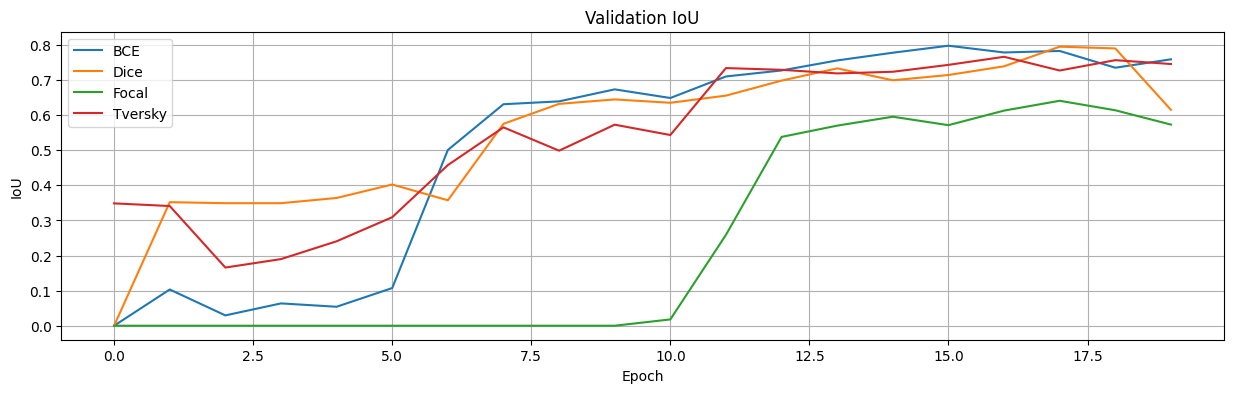

In [70]:
import matplotlib.pyplot as plt

# Словарь с подписями и данными
models_stats = {
    "BCE": statistics,
    "Dice": statistics_dice,
    "Focal": statistics_focal,
    "Tversky": statistics_tversky
}

# ---------- Plot: Validation IoU ----------
plt.figure()
for name, stats in models_stats.items():
    plt.plot(stats['val_iou'], label=name)
plt.title('Validation IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.grid(True)
plt.show()


# Новая модель!

## U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

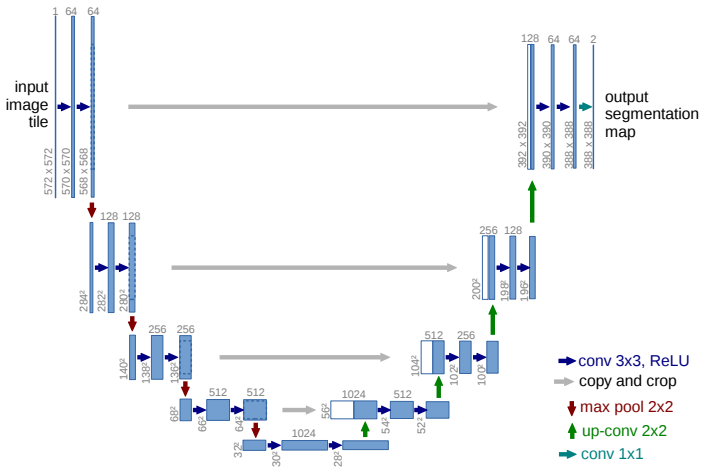

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [63]:
import copy
import os
import random
import shutil
import zipfile
from math import atan2, cos, sin, sqrt, pi, log

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
from numpy import linalg as LA
from torch import optim, nn
from torch.utils.data import DataLoader, random_split
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from tqdm import tqdm

In [64]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv_op(x)
    

class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)

        return down, p


class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x1, x2], 1)
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, in_channels = 3, num_classes = 1):
        super().__init__()
        self.down_convolution_1 = DownSample(in_channels, 64)
        self.down_convolution_2 = DownSample(64, 128)
        self.down_convolution_3 = DownSample(128, 256)
        self.down_convolution_4 = DownSample(256, 512)

        self.bottle_neck = DoubleConv(512, 1024)

        self.up_convolution_1 = UpSample(1024, 512)
        self.up_convolution_2 = UpSample(512, 256)
        self.up_convolution_3 = UpSample(256, 128)
        self.up_convolution_4 = UpSample(128, 64)

        self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
        down_1, p1 = self.down_convolution_1(x)
        down_2, p2 = self.down_convolution_2(p1)
        down_3, p3 = self.down_convolution_3(p2)
        down_4, p4 = self.down_convolution_4(p3)

        b = self.bottle_neck(p4)

        up_1 = self.up_convolution_1(b, down_4)
        up_2 = self.up_convolution_2(up_1, down_3)
        up_3 = self.up_convolution_3(up_2, down_2)
        up_4 = self.up_convolution_4(up_3, down_1)

        out = self.out(up_4)
        return out

In [65]:
unet_model = UNet()
unet_model(next(iter(train_dataloader))[0])

tensor([[[[0.0897, 0.0914, 0.0920,  ..., 0.0917, 0.0907, 0.0898],
          [0.0910, 0.0930, 0.0939,  ..., 0.0938, 0.0915, 0.0898],
          [0.0889, 0.0907, 0.0906,  ..., 0.0902, 0.0897, 0.0895],
          ...,
          [0.0883, 0.0911, 0.0905,  ..., 0.0907, 0.0901, 0.0897],
          [0.0889, 0.0908, 0.0902,  ..., 0.0903, 0.0897, 0.0892],
          [0.0867, 0.0873, 0.0871,  ..., 0.0868, 0.0868, 0.0872]]],


        [[[0.0897, 0.0913, 0.0919,  ..., 0.0917, 0.0904, 0.0895],
          [0.0912, 0.0933, 0.0939,  ..., 0.0934, 0.0911, 0.0892],
          [0.0891, 0.0910, 0.0908,  ..., 0.0902, 0.0892, 0.0890],
          ...,
          [0.0885, 0.0911, 0.0902,  ..., 0.0902, 0.0893, 0.0891],
          [0.0890, 0.0907, 0.0899,  ..., 0.0897, 0.0891, 0.0887],
          [0.0868, 0.0872, 0.0868,  ..., 0.0865, 0.0864, 0.0871]]],


        [[[0.0897, 0.0914, 0.0919,  ..., 0.0916, 0.0903, 0.0895],
          [0.0911, 0.0930, 0.0938,  ..., 0.0934, 0.0914, 0.0895],
          [0.0890, 0.0907, 0.0905,  ..

## Обучите UNet

In [ ]:
ф

Задание: обучите UNet на всех трех лоссах: BCE, Dice, Focal и сравните результаты с SegNet:
*   Какая модель дает лучшие значения по метрике?
*   Какая модель дает лучшие значения по лоссам?
*   Какая модель обучается быстрее?
*   Сравните визуально результаты SegNet и UNet.

Напишите развернутый ответ на вопросы.



### Model BCE Loss

In [71]:
unet_model_bce_loss = UNet().to(device)

model = unet_model_bce_loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss(reduction='sum')
epochs = 40


ckpt_path = './unet_bce_checkpoints'
os.makedirs(ckpt_path, exist_ok=True) 

In [72]:
model, statistics_unet_bce = train(model, optimizer, criterion, epochs, train_dataloader, valid_dataloader, device, ckpt_path)

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


Epoch 0: train loss = 35280752.0
Epoch 0: val loss = 1052048.25
Epoch 0: val iou = 0.0


  5%|▌         | 2/40 [00:05<01:51,  2.93s/it]

Epoch 1: train loss = 1089893.5
Epoch 1: val loss = 1098541.75
Epoch 1: val iou = 0.0


  8%|▊         | 3/40 [00:08<01:46,  2.87s/it]

Epoch 2: train loss = 1096399.75
Epoch 2: val loss = 1101698.625
Epoch 2: val iou = 0.0


 10%|█         | 4/40 [00:11<01:42,  2.84s/it]

Epoch 3: train loss = 1097022.0
Epoch 3: val loss = 1099378.5
Epoch 3: val iou = 0.0


 12%|█▎        | 5/40 [00:14<01:38,  2.83s/it]

Epoch 4: train loss = 1093129.375
Epoch 4: val loss = 1093576.625
Epoch 4: val iou = 0.0


 15%|█▌        | 6/40 [00:17<01:35,  2.81s/it]

Epoch 5: train loss = 1084776.875
Epoch 5: val loss = 1083807.5
Epoch 5: val iou = 0.0


 18%|█▊        | 7/40 [00:19<01:32,  2.81s/it]

Epoch 6: train loss = 1069313.5
Epoch 6: val loss = 1063052.0
Epoch 6: val iou = 0.0


 20%|██        | 8/40 [00:22<01:32,  2.88s/it]

Epoch 7: train loss = 1039174.8125
Epoch 7: val loss = 1011902.8125
Epoch 7: val iou = 0.0


100%|██████████| 2/2 [00:00<00:00,  4.59it/s]


Epoch 8: train loss = 981808.9375
Epoch 8: val loss = 993100.5
Epoch 8: val iou = 0.0


100%|██████████| 2/2 [00:00<00:00,  4.64it/s]


Epoch 9: train loss = 949068.375
Epoch 9: val loss = 935367.5
Epoch 9: val iou = 0.0


100%|██████████| 2/2 [00:00<00:00,  4.65it/s]


Epoch 10: train loss = 882001.3125
Epoch 10: val loss = 856580.375
Epoch 10: val iou = 0.054444145411252975


100%|██████████| 2/2 [00:00<00:00,  4.64it/s]


Epoch 11: train loss = 837493.5
Epoch 11: val loss = 771183.1875
Epoch 11: val iou = 0.48527365922927856


100%|██████████| 2/2 [00:00<00:00,  4.62it/s]


Epoch 12: train loss = 754857.625
Epoch 12: val loss = 763421.1875
Epoch 12: val iou = 0.5146517753601074


100%|██████████| 2/2 [00:00<00:00,  4.62it/s]


Epoch 13: train loss = 734903.0625
Epoch 13: val loss = 746713.25
Epoch 13: val iou = 0.5669684410095215


 38%|███▊      | 15/40 [00:44<01:14,  2.97s/it]

Epoch 14: train loss = 723479.25
Epoch 14: val loss = 760615.3125
Epoch 14: val iou = 0.4937322735786438


100%|██████████| 2/2 [00:00<00:00,  4.60it/s]


Epoch 15: train loss = 701681.25
Epoch 15: val loss = 684269.0
Epoch 15: val iou = 0.5545463562011719


 42%|████▎     | 17/40 [00:50<01:07,  2.94s/it]

Epoch 16: train loss = 675337.0
Epoch 16: val loss = 837722.625
Epoch 16: val iou = 0.5700180530548096


100%|██████████| 2/2 [00:00<00:00,  4.63it/s]


Epoch 17: train loss = 765518.5
Epoch 17: val loss = 669543.375
Epoch 17: val iou = 0.5484007596969604


100%|██████████| 2/2 [00:00<00:00,  4.61it/s]


Epoch 18: train loss = 736579.1875
Epoch 18: val loss = 667847.25
Epoch 18: val iou = 0.57490074634552


 50%|█████     | 20/40 [00:58<00:59,  2.95s/it]

Epoch 19: train loss = 699578.0
Epoch 19: val loss = 722918.625
Epoch 19: val iou = 0.47312405705451965


 52%|█████▎    | 21/40 [01:01<00:55,  2.91s/it]

Epoch 20: train loss = 702198.375
Epoch 20: val loss = 675830.6875
Epoch 20: val iou = 0.5938804149627686


100%|██████████| 2/2 [00:00<00:00,  4.64it/s]


Epoch 21: train loss = 662765.5
Epoch 21: val loss = 663438.25
Epoch 21: val iou = 0.5342341661453247


100%|██████████| 2/2 [00:00<00:00,  4.61it/s]


Epoch 22: train loss = 634535.0625
Epoch 22: val loss = 614604.8125
Epoch 22: val iou = 0.5940043926239014


100%|██████████| 2/2 [00:00<00:00,  4.63it/s]


Epoch 23: train loss = 621140.5
Epoch 23: val loss = 603757.875
Epoch 23: val iou = 0.5985895395278931


100%|██████████| 2/2 [00:00<00:00,  4.63it/s]


Epoch 24: train loss = 780978.625
Epoch 24: val loss = 589006.9375
Epoch 24: val iou = 0.6108812093734741


 65%|██████▌   | 26/40 [01:16<00:41,  2.95s/it]

Epoch 25: train loss = 611535.3125
Epoch 25: val loss = 599384.75
Epoch 25: val iou = 0.5901179909706116


100%|██████████| 2/2 [00:00<00:00,  4.60it/s]


Epoch 26: train loss = 605107.1875
Epoch 26: val loss = 583232.875
Epoch 26: val iou = 0.6187522411346436


100%|██████████| 2/2 [00:00<00:00,  4.65it/s]


Epoch 27: train loss = 606065.75
Epoch 27: val loss = 563832.6875
Epoch 27: val iou = 0.6277037858963013


 72%|███████▎  | 29/40 [01:25<00:33,  3.02s/it]

Epoch 28: train loss = 574701.875
Epoch 28: val loss = 543800.375
Epoch 28: val iou = 0.6418459415435791


 75%|███████▌  | 30/40 [01:28<00:29,  2.96s/it]

Epoch 29: train loss = 583047.625
Epoch 29: val loss = 588277.9375
Epoch 29: val iou = 0.5756614208221436


100%|██████████| 2/2 [00:00<00:00,  4.62it/s]


Epoch 30: train loss = 576317.75
Epoch 30: val loss = 532351.0
Epoch 30: val iou = 0.640771210193634


 80%|████████  | 32/40 [01:34<00:24,  3.01s/it]

Epoch 31: train loss = 555673.875
Epoch 31: val loss = 530633.125
Epoch 31: val iou = 0.6351685523986816


100%|██████████| 2/2 [00:00<00:00,  4.66it/s]


Epoch 32: train loss = 571084.25
Epoch 32: val loss = 515887.21875
Epoch 32: val iou = 0.6519571542739868


100%|██████████| 2/2 [00:00<00:00,  4.63it/s]


Epoch 33: train loss = 589363.375
Epoch 33: val loss = 508452.375
Epoch 33: val iou = 0.6550449132919312


 88%|████████▊ | 35/40 [01:43<00:14,  2.97s/it]

Epoch 34: train loss = 570954.4375
Epoch 34: val loss = 547850.5
Epoch 34: val iou = 0.6002028584480286


100%|██████████| 2/2 [00:00<00:00,  4.59it/s]


Epoch 35: train loss = 585902.125
Epoch 35: val loss = 486524.875
Epoch 35: val iou = 0.7119176387786865


 92%|█████████▎| 37/40 [01:49<00:08,  2.95s/it]

Epoch 36: train loss = 512387.75
Epoch 36: val loss = 512201.8125
Epoch 36: val iou = 0.6494378447532654


100%|██████████| 2/2 [00:00<00:00,  4.64it/s]


Epoch 37: train loss = 516113.9375
Epoch 37: val loss = 461064.0
Epoch 37: val iou = 0.729620099067688


 98%|█████████▊| 39/40 [01:55<00:02,  2.93s/it]

Epoch 38: train loss = 504882.875
Epoch 38: val loss = 483928.625
Epoch 38: val iou = 0.7259470224380493


100%|██████████| 40/40 [01:58<00:00,  2.96s/it]

Epoch 39: train loss = 505828.125
Epoch 39: val loss = 470745.125
Epoch 39: val iou = 0.6783484220504761


In [73]:
test(model, test_dataloader, device, ckpt_path, "best_val_loss.pt")

/tmp/ipykernel_183/1397368121.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'{ckpt_path}/{ckpt_name}'))


tensor(0.6820, device='cuda:0')

### Model Dice Loss

In [74]:
unet_model_dice_loss = UNet().to(device)

model = unet_model_dice_loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = dice
epochs = 20

ckpt_path = './unet_dice_checkpoints'
os.makedirs(ckpt_path, exist_ok=True) 


In [75]:
model, statistics_unet_dice = train(model, optimizer, criterion, epochs, train_dataloader, valid_dataloader, device, ckpt_path)

  5%|▌         | 1/20 [00:02<00:56,  2.98s/it]

Epoch 0: train loss = 0.1730094999074936
Epoch 0: val loss = 0.7527914047241211
Epoch 0: val iou = 0.0


100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


Epoch 1: train loss = 0.7092421054840088
Epoch 1: val loss = 0.7206069231033325
Epoch 1: val iou = 0.0


100%|██████████| 2/2 [00:00<00:00,  4.45it/s]


Epoch 2: train loss = 0.6608647108078003
Epoch 2: val loss = 0.6276612281799316
Epoch 2: val iou = 0.0


100%|██████████| 2/2 [00:00<00:00,  4.51it/s]


Epoch 3: train loss = 0.3915700316429138
Epoch 3: val loss = 0.2465987503528595
Epoch 3: val iou = 0.0


100%|██████████| 2/2 [00:00<00:00,  4.49it/s]


Epoch 4: train loss = 0.1633407473564148
Epoch 4: val loss = 0.16843874752521515
Epoch 4: val iou = 0.0


100%|██████████| 2/2 [00:00<00:00,  4.51it/s]


Epoch 5: train loss = 0.11350087821483612
Epoch 5: val loss = 0.0798841193318367
Epoch 5: val iou = 0.0


 35%|███▌      | 7/20 [00:21<00:40,  3.08s/it]

Epoch 6: train loss = 0.07530040293931961
Epoch 6: val loss = 0.07879990339279175
Epoch 6: val iou = 0.0


100%|██████████| 2/2 [00:00<00:00,  4.48it/s]


Epoch 7: train loss = 0.045986998826265335
Epoch 7: val loss = 0.02698911912739277
Epoch 7: val iou = 0.0


100%|██████████| 2/2 [00:00<00:00,  4.50it/s]


Epoch 8: train loss = 0.01894734427332878
Epoch 8: val loss = 0.010920964181423187
Epoch 8: val iou = 0.0


100%|██████████| 2/2 [00:00<00:00,  4.47it/s]


Epoch 9: train loss = 0.009611496701836586
Epoch 9: val loss = 0.000961803481914103
Epoch 9: val iou = 0.0


100%|██████████| 2/2 [00:00<00:00,  4.48it/s]


Epoch 10: train loss = 0.0011702068150043488
Epoch 10: val loss = 0.00017513494822196662
Epoch 10: val iou = 0.0


100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


Epoch 11: train loss = 0.00016544750542379916
Epoch 11: val loss = 7.153672777349129e-05
Epoch 11: val iou = 0.0


100%|██████████| 2/2 [00:00<00:00,  4.46it/s]


Epoch 12: train loss = 2.5851750251604244e-06
Epoch 12: val loss = -0.0001652855717111379
Epoch 12: val iou = 0.3499864339828491


100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


Epoch 13: train loss = -0.0023764148354530334
Epoch 13: val loss = -0.05529741570353508
Epoch 13: val iou = 0.349440336227417


 75%|███████▌  | 15/20 [00:46<00:15,  3.02s/it]

Epoch 14: train loss = 0.4622427225112915
Epoch 14: val loss = 0.7033668756484985
Epoch 14: val iou = 0.3490740954875946


 80%|████████  | 16/20 [00:48<00:11,  2.96s/it]

Epoch 15: train loss = 0.6601515412330627
Epoch 15: val loss = 0.6721038818359375
Epoch 15: val iou = 0.3490740954875946


 85%|████████▌ | 17/20 [00:51<00:08,  2.92s/it]

Epoch 16: train loss = 0.6126631498336792
Epoch 16: val loss = 0.5870242118835449
Epoch 16: val iou = 0.3490740954875946


 90%|█████████ | 18/20 [00:54<00:05,  2.89s/it]

Epoch 17: train loss = 0.5011128187179565
Epoch 17: val loss = 0.3948490023612976
Epoch 17: val iou = 0.349074125289917


 95%|█████████▌| 19/20 [00:57<00:02,  2.87s/it]

Epoch 18: train loss = 0.27768659591674805
Epoch 18: val loss = 0.18337807059288025
Epoch 18: val iou = 0.3490740954875946


100%|██████████| 20/20 [01:00<00:00,  3.01s/it]

Epoch 19: train loss = 0.14367780089378357
Epoch 19: val loss = 0.10485793650150299
Epoch 19: val iou = 0.3490740954875946


In [76]:
test(model, test_dataloader, device, ckpt_path, "best_val_loss.pt")

/tmp/ipykernel_183/1397368121.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'{ckpt_path}/{ckpt_name}'))


tensor(0.2762, device='cuda:0')

### Model Focal Loss

In [77]:
unet_model_focal_loss = UNet().to(device)

from torchvision.ops import sigmoid_focal_loss


def focal_loss_fn(logits, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    return sigmoid_focal_loss(logits, targets, alpha=alpha, gamma=gamma, reduction=reduction)


model = unet_model_focal_loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = focal_loss_fn
epochs = 20

ckpt_path = './unet_focal_checkpoints'
os.makedirs(ckpt_path, exist_ok=True) 


In [78]:
model, statistics_focal = train(model, optimizer, criterion, epochs, train_dataloader, valid_dataloader, device, ckpt_path)

  5%|▌         | 1/20 [00:03<00:57,  3.01s/it]

Epoch 0: train loss = 0.08881442248821259
Epoch 0: val loss = 0.2709691822528839
Epoch 0: val iou = 0.0


100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


Epoch 1: train loss = 0.10149645805358887
Epoch 1: val loss = 0.06627564132213593
Epoch 1: val iou = 0.0


100%|██████████| 2/2 [00:00<00:00,  4.60it/s]


Epoch 2: train loss = 0.06339462101459503
Epoch 2: val loss = 0.057185620069503784
Epoch 2: val iou = 0.0


 20%|██        | 4/20 [00:11<00:47,  2.96s/it]

Epoch 3: train loss = 0.05599155277013779
Epoch 3: val loss = 0.0576896071434021
Epoch 3: val iou = 0.0


100%|██████████| 2/2 [00:00<00:00,  4.63it/s]


Epoch 4: train loss = 0.05375319719314575
Epoch 4: val loss = 0.05290258675813675
Epoch 4: val iou = 0.0


100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


Epoch 5: train loss = 0.050986871123313904
Epoch 5: val loss = 0.05067795142531395
Epoch 5: val iou = 0.0


 35%|███▌      | 7/20 [00:20<00:38,  2.95s/it]

Epoch 6: train loss = 0.05200561136007309
Epoch 6: val loss = 0.053326237946748734
Epoch 6: val iou = 0.0


 40%|████      | 8/20 [00:24<00:35,  2.99s/it]

Epoch 7: train loss = 0.04996257275342941
Epoch 7: val loss = 0.04717765003442764
Epoch 7: val iou = 0.0003262489044573158


100%|██████████| 2/2 [00:00<00:00,  4.61it/s]


Epoch 8: train loss = 0.04632183909416199
Epoch 8: val loss = 0.04557039588689804
Epoch 8: val iou = 0.0


100%|██████████| 2/2 [00:00<00:00,  4.64it/s]


Epoch 9: train loss = 0.04503680765628815
Epoch 9: val loss = 0.04482448101043701
Epoch 9: val iou = 0.0


100%|██████████| 2/2 [00:00<00:00,  4.56it/s]


Epoch 10: train loss = 0.0434727780520916
Epoch 10: val loss = 0.04308192431926727
Epoch 10: val iou = 0.0


100%|██████████| 2/2 [00:00<00:00,  4.63it/s]


Epoch 11: train loss = 0.04288221150636673
Epoch 11: val loss = 0.042088788002729416
Epoch 11: val iou = 0.0


100%|██████████| 2/2 [00:00<00:00,  4.62it/s]


Epoch 12: train loss = 0.042336009442806244
Epoch 12: val loss = 0.04109834507107735
Epoch 12: val iou = 0.02037990465760231


100%|██████████| 2/2 [00:00<00:00,  4.59it/s]


Epoch 13: train loss = 0.041310086846351624
Epoch 13: val loss = 0.040785498917102814
Epoch 13: val iou = 0.20702087879180908


100%|██████████| 2/2 [00:00<00:00,  4.61it/s]


Epoch 14: train loss = 0.04096933826804161
Epoch 14: val loss = 0.03945104032754898
Epoch 14: val iou = 0.3774644732475281


100%|██████████| 2/2 [00:00<00:00,  4.58it/s]


Epoch 15: train loss = 0.03984326124191284
Epoch 15: val loss = 0.03701554983854294
Epoch 15: val iou = 0.6578594446182251


 85%|████████▌ | 17/20 [00:51<00:09,  3.01s/it]

Epoch 16: train loss = 0.04365966096520424
Epoch 16: val loss = 0.03982655704021454
Epoch 16: val iou = 0.297849178314209


 90%|█████████ | 18/20 [00:54<00:05,  2.95s/it]

Epoch 17: train loss = 0.04304810240864754
Epoch 17: val loss = 0.04141850769519806
Epoch 17: val iou = 0.4484226703643799


 95%|█████████▌| 19/20 [00:57<00:02,  2.91s/it]

Epoch 18: train loss = 0.04225040227174759
Epoch 18: val loss = 0.04338737949728966
Epoch 18: val iou = 0.17166702449321747


100%|██████████| 20/20 [01:00<00:00,  3.00s/it]

Epoch 19: train loss = 0.04102848470211029
Epoch 19: val loss = 0.04051690548658371
Epoch 19: val iou = 0.4642397165298462


In [79]:
test(model, test_dataloader, device, ckpt_path, "best_val_loss.pt")

/tmp/ipykernel_183/1397368121.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'{ckpt_path}/{ckpt_name}'))


tensor(0.6733, device='cuda:0')